In [1]:
import subprocess
import tempfile
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random

### SET CWD TO REPO ROOT
os.chdir(Path.cwd().parent)
print("CWD now:", Path.cwd())

from rtl.py_lmul import lmul
from rtl.lmul_tester import BatchLMULTester

CWD now: /workspaces/LMUL-Hardware-Acceleration


In [2]:
def float_to_bf16(f: float) -> int:
    """Convert float32 to bfloat16 (16-bit)"""
    if np.isnan(f):
        return 0x7FC0
    if np.isinf(f):
        return 0xFF80 if f < 0 else 0x7F80
    f = np.clip(f, -3.4e38, 3.4e38)
    f32_bits = struct.unpack('>I', struct.pack('>f', np.float32(f)))[0]
    bf16_bits = (f32_bits >> 16) & 0xFFFF
    return bf16_bits

def bf16_to_float(bf16: int) -> float:
    """Convert bfloat16 to float32"""
    f32_bits = (bf16 & 0xFFFF) << 16
    return struct.unpack('>f', struct.pack('>I', f32_bits))[0]

print("✓ BF16 utilities ready")



✓ BF16 utilities ready


In [3]:
batch_tester = BatchLMULTester()
print("✓ Batch tester ready")

✓ Batch tester ready


In [4]:
# Generate test data
N = 100_000
np.random.seed(42)
test_data = []
for i in range(N):
    a_float = np.random.uniform(-10, 10)
    b_float = np.random.uniform(-10, 10)
    a_bf16 = float_to_bf16(a_float)
    b_bf16 = float_to_bf16(b_float)
    test_data.append((a_bf16, b_bf16, a_float, b_float))

print("✓ Test data generated")

✓ Test data generated


In [5]:
# Benchmark 1: LMUL Hardware (batch mode)
print("1. LMUL Hardware (batch simulation):")
SIMULATION_CLOCK_HZ = 100_000_000  # 100 MHz
test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]

hw_results_bf16, hw_time, cycles_window, total_cycles = batch_tester.test_batch(test_pairs)

hw_cycles_per_op = cycles_window / N
hw_latency_per_op = hw_cycles_per_op / SIMULATION_CLOCK_HZ  # seconds
hw_total_latency = cycles_window / SIMULATION_CLOCK_HZ  # seconds
hw_throughput = SIMULATION_CLOCK_HZ / hw_cycles_per_op  # ops/sec

print(f"   Total time: {hw_time:.3f}s")
print(f"   Total cycles: {cycles_window}")
print(f"   Cycles per op: {hw_cycles_per_op:.2f} cycles/op")
print(f"   Theoretical latency: {hw_total_latency:.6f}s")
print(f"   Theoretical latency per op: {hw_latency_per_op*1e6:.2f}μs")
print(f"   Theoretical throughput: {hw_throughput:.0f} ops/sec")

1. LMUL Hardware (batch simulation):
   Total time: 0.938s
   Total cycles: 100001
   Cycles per op: 1.00 cycles/op
   Theoretical latency: 0.001000s
   Theoretical latency per op: 0.01μs
   Theoretical throughput: 99999000 ops/sec


In [6]:
# Benchmark 2: Python float32
print("\n2. Python float32 multiplication:")
start = time.time()
py_results = []
for _, _, a_float, b_float in test_data:
    result = a_float * b_float
    py_results.append(result)
py_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {py_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/py_time:.0f} ops/sec")


2. Python float32 multiplication:
   Total time: 0.037878s
   Per operation: 0.38μs
   Throughput: 2640069 ops/sec


In [7]:
# Benchmark 3: NumPy vectorized
print("\n3. NumPy vectorized multiplication:")
a_array = np.array([d[2] for d in test_data], dtype=np.float32)
b_array = np.array([d[3] for d in test_data], dtype=np.float32)

start = time.time()
np_results = a_array * b_array
np_time = time.time() - start
np_per_op = np_time / N

print(f"   Total time: {np_time:.6f}s")
print(f"   Per operation: {np_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/np_time:.0f} ops/sec")


3. NumPy vectorized multiplication:
   Total time: 0.001306s
   Per operation: 0.01μs
   Throughput: 76580318 ops/sec


In [8]:
# Benchmark 4: Python float32
print("\n2. Python LMUL:")
start = time.time()
pylmul_results = []
for a_float, b_float, _, _ in test_data:
    result = lmul(a_float, b_float)
    pylmul_results.append(result)
pylmul_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {pylmul_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/pylmul_time:.0f} ops/sec")


2. Python LMUL:


   Total time: 0.062434s
   Per operation: 0.38μs
   Throughput: 1601692 ops/sec


In [9]:
# Summary
print("\n" + "-" * 60)
print("SPEED COMPARISON:")
print("-" * 60)
print(f"Python FP32:         1.00x (baseline)")
print(f"NumPy vectorized:    {py_time/np_time:.2f}x faster")
print(f"LMUL batch sim:      {py_time/hw_total_latency:.2f}x vs Python")
print(f"                     ({np_time/hw_total_latency:.2f}x vs NumPy)")
print(f"Python LMUL:         {py_time/pylmul_time:.2f}x vs Python")



------------------------------------------------------------
SPEED COMPARISON:
------------------------------------------------------------
Python FP32:         1.00x (baseline)
NumPy vectorized:    29.01x faster
LMUL batch sim:      37.88x vs Python
                     (1.31x vs NumPy)
Python LMUL:         0.61x vs Python


In [10]:
test_sizes = np.array([10 ** i for i in range(1, 6)])
py_times = []
np_times = []
lmul_times = []
pylmul_times = []

for size in test_sizes:
    # Generate random test data
    test_data = []
    for _ in range(size):
        a_float = np.random.uniform(-10, 10)
        b_float = np.random.uniform(-10, 10)
        a_bf16 = float_to_bf16(a_float)
        b_bf16 = float_to_bf16(b_float)
        test_data.append((a_bf16, b_bf16, a_float, b_float))

    # Benchmark Python float32
    start = time.time()
    py_results = [a_float * b_float for _, _, a_float, b_float in test_data]
    py_times.append(time.time() - start)

    # Benchmark NumPy vectorized
    a_array = np.array([d[2] for d in test_data], dtype=np.float32)
    b_array = np.array([d[3] for d in test_data], dtype=np.float32)
    start = time.time()
    np_results = a_array * b_array
    np_times.append(time.time() - start)

    # Benchmark LMUL Hardware (batch mode)
    test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]
    _, _, _, total_cycles = batch_tester.test_batch(test_pairs)
    lmul_times.append(total_cycles / SIMULATION_CLOCK_HZ)

    # Benchmark Python LMUL
    start = time.time()
    pylmul_results = [lmul(a_float, b_float) for a_float, b_float, _, _ in test_data]
    pylmul_times.append(time.time() - start)

In [11]:
py_op_times = np.array(py_times) / test_sizes
np_op_times = np.array(np_times) / test_sizes
lmul_op_times = np.array(lmul_times) / test_sizes
pylmul_op_times = np.array(pylmul_times) / test_sizes

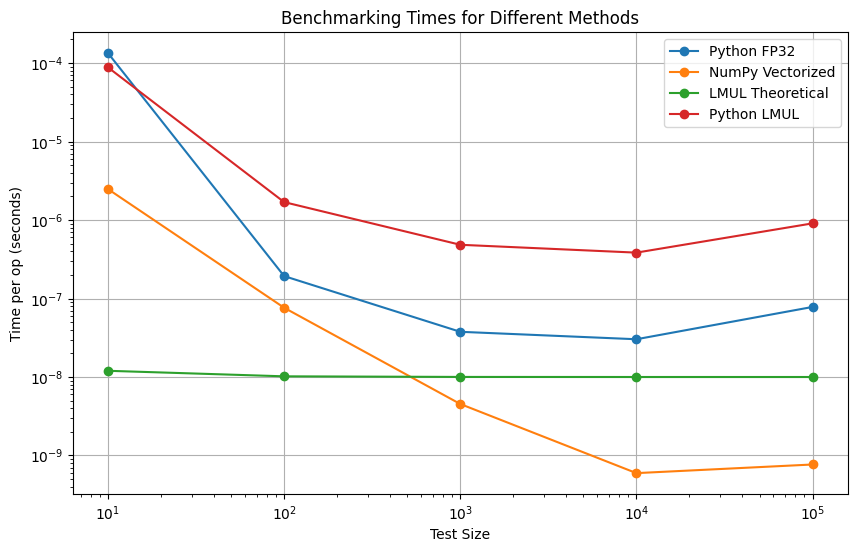

In [12]:
plt.figure(figsize=(10, 6))

plt.xscale('log')
plt.yscale('log')

plt.plot(test_sizes, py_op_times, label='Python FP32', marker='o')
plt.plot(test_sizes, np_op_times, label='NumPy Vectorized', marker='o')
plt.plot(test_sizes, lmul_op_times, label='LMUL Theoretical', marker='o')
plt.plot(test_sizes, pylmul_op_times, label='Python LMUL', marker='o')

plt.xlabel('Test Size')
plt.ylabel('Time per op (seconds)')
plt.title('Benchmarking Times for Different Methods')
plt.legend()
plt.grid(True)
plt.show()
